# Blue Book for Bulldozers

## Data Description

The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## I. Defining a Problem and Assembling a dataset
- What will your input data be ?
    - **Usage, Equipment Type, and Configuration features** about Heavy Equipment. Examples of Features:
        - **SalesID**: The unique identifier of the sale.
        - **MachineID**: The unique identifier of a Machine. A Machine can be sold multiple times.
        - **SaleDate**: The Date of the sale.
- What are you trying to predict ?
    - **SalePrice**: What the Machine Sold for at the Action.
- What type of problem are you facing ?
    - **Regression** (Predict the Numerical Price of the Heavy Equipment at sale).

## II. Choosing a Measure of Success
- To control something, you need to be able to observe it.
    - The measure of sucess for this competition is **`RMSLE`** (Root Mean Squared Log Error).
        - Meaning we're going to score based on the difference between the log of our predictions and the log of the targets.
        - The organizers are telling us they care about ratios more than differences.
- To Achieve success, you must define what you mean by success.
    - We need a top 5% Public Leaderboard score, meaning **$< 0.24132$** **(DONE)**.

## Imports

In [31]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [33]:
PATH = "data/bulldozers/"

In [34]:
!ls {PATH}

Train.csv


In [35]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"]); len(df_raw)

401125

We first check if the data is sorted by `saledate`:

In [37]:
df_raw.copy().equals(df_raw.sort_values(by='saledate'))

False

The data is not ordered, let's sort it by saledate first:

In [39]:
df_raw.sort_values(by='saledate', inplace=True)

**I don't have a Local GPU so i can't support training ML Algos on my setup, to make it easier, I'll just sample the last 50k rows of data:**

In [26]:
df_train = df_raw[-100000:].copy()

In [27]:
del(df_raw)

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

**Let's take a look at the columns we have:**

In [66]:
df_train.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [67]:
def display_all(df):
    with pd.option_context("display.max_rows", 33, "display.max_columns", 7): 
        display(df)

In [68]:
display_all(df_train.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [69]:
display_all(df_train.describe(include='all').T)

,count,unique,top,...,50%,75%,max
SalesID,100000,NaN,NaN,...,2.41413e+06,2.72333e+06,6.33334e+06
SalePrice,100000,NaN,NaN,...,26000,44000,141000
MachineID,100000,NaN,NaN,...,1.49877e+06,1.76601e+06,2.48633e+06
ModelID,100000,NaN,NaN,...,4607,12919,37198
datasource,100000,NaN,NaN,...,136,149,172
auctioneerID,84307,NaN,NaN,...,1,2,99
YearMade,100000,NaN,NaN,...,2000,2004,2013
MachineHoursCurrentMeter,91215,NaN,NaN,...,0,2247.5,2.4833e+06
UsageBand,34799,3,Medium,...,NaN,NaN,NaN
saledate,100000,984,2009-02-16 00:00:00,...,NaN,NaN,NaN


**Don't look at the data at the beginning to not form any assumptions that might cause a bias to be reinforced.**

**Do Machine Learning Driven EDA (Exploratory Data Analysis) espacially when you have a lot of featrues and you want to put your efforts where they matter.**

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [70]:
df_train.SalePrice = np.log(df_train.SalePrice)

### Initial processing

In [12]:
m = RandomForestRegressor(n_jobs=-1)
# The following code is supposed to fail due to string values in the input data
m.fit(df_train.drop('SalePrice', axis=1), df_train.SalePrice)

/anaconda3/envs/fastai-env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'Low'

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

**Dates are one of the most interesting feature engineering datasets to explore, with infinite number of possible extracted features, you need to focus on ideas and features that relate to your problem.**

In [71]:
add_datepart(df_train, 'saledate')
df_train.saleYear.head()

301125    2008
301126    2008
301127    2007
301128    2007
301129    2008
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

**Use "apply_cats" to make sure the mapping used on the training set are the same on the test set**

In [72]:
train_cats(df_train)

We can specify the order to use for categorical variables if we wish:

In [73]:
df_train.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

**It's better to make it easier for decisions trees to create logical splits.**

In [74]:
df_train.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [75]:
df_train.UsageBand = df_train.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [76]:
display_all(df_train.isnull().sum().sort_index()/len(df_train))

Backhoe_Mounting        0.80107
Blade_Extension         0.93303
Blade_Type              0.79974
Blade_Width             0.93303
Coupler                 0.44350
Coupler_System          0.88729
Differential_Type       0.82075
Drive_System            0.76264
Enclosure               0.00070
Enclosure_Type          0.93303
Engine_Horsepower       0.93303
Forks                   0.53733
Grouser_Tracks          0.88742
Grouser_Type            0.73903
Hydraulics              0.17363
Hydraulics_Flow         0.88742
                         ...   
fiProductClassDesc      0.00000
fiSecondaryDesc         0.28313
saleDay                 0.00000
saleDayofweek           0.00000
saleDayofyear           0.00000
saleElapsed             0.00000
saleIs_month_end        0.00000
saleIs_month_start      0.00000
saleIs_quarter_end      0.00000
saleIs_quarter_start    0.00000
saleIs_year_end         0.00000
saleIs_year_start       0.00000
saleMonth               0.00000
saleWeek                0.00000
saleYear

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [77]:
#os.makedirs('data/tmp', exist_ok=True)
#df_train.to_feather('data/tmp/bulldozers-raw')

### Pre-processing

In the future we can simply read it from this fast format.

In [78]:
#df_raw = pd.read_feather('data/tmp/bulldozers-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [79]:
df, y, nas = proc_df(df_train, 'SalePrice')

We now have something we can pass to a random forest!

In [80]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/anaconda3/envs/fastai-env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9812948918578172

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [81]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_train, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((88000, 66), (88000,), (12000, 66))

**Creating your validation set is the most important thing you need to be doing when dealing with a machine learning project.**

* Sometimes you do modelling, everything works well, but when you put it on production, it doesn't work.
 * This means one of two things, the data pipeline in production is broken, or (and in most cases) you didn't valdiate your model well.
 * Production data should be of the same structure as Training/Validation/Testing data.

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [82]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [83]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/anaconda3/envs/fastai-env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 13.5 s, sys: 137 ms, total: 13.6 s
Wall time: 4.54 s
[0.09778360276123849, 0.26092547262369525, 0.9801836670430519, 0.8784147389507297]


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

**Practical Advice**
* **If a cell takes more than 10s to run, it's too slow to do interactive Machine Learning or Data Analysis, find ways to reduce run time to less than 10secs for all cells or you'll be lagging.**
* **Work with sub ~10secs cells and at the end of the day you can train/validate a model that takes time**.

## Speeding things up

In [84]:
df_trn, y_trn, nas = proc_df(df_train, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [85]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/anaconda3/envs/fastai-env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 2.87 s, sys: 33.7 ms, total: 2.91 s
Wall time: 1.09 s
[0.11036205971828465, 0.3348589674115337, 0.9741514074894383, 0.7997503151059326]


## Single tree

**A tree in sklearn is called an estimator.**

In [86]:
m = RandomForestRegressor(n_estimators=10, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.534509203182216, 0.57772348869026, 0.39367192178727317, 0.403942682052183]


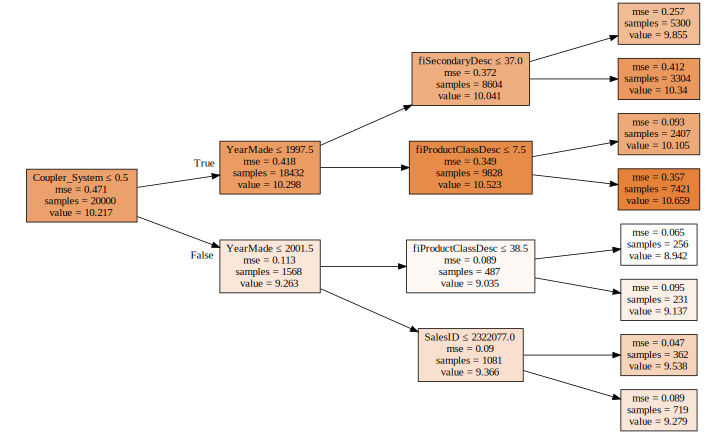

In [87]:
draw_tree(m.estimators_[0], df_trn, precision=3)

**Notes:**

* **To decide on a split, we look at all the possible splits on all features and assign each split a score of a weighted average** $mse_1*samples_2 + mse_2*samples_2$, **then we choose the split with the lowest weighted average**.
* **We dont need a split of three leafs because we can split againt using the same variable, so a binary split is enough.**

Let's see what happens if we create a bigger tree.

In [88]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[9.315293853352738e-17, 0.4781396297968205, 1.0, 0.591720611256901]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

**The Random forest is a way of bagging trees, the idea behind bagging is pretty simple:**
* **What if we've created five different models, each of witch is somewhat predictive, and the models weren't at all correlated with each other.**
* **This would mean that the five models would have found different insights in the data structure.**
* **And so if you took the average of these five models we're bringing in the insights from each one of them.**
* **This way of averaging models is a technique that belongs to ensembling.**
* **The key Idea is that the average of uncorrelated errors is 0 (averaging individual predictions gets you closer to the target value) and what's left is the true relationship [?].**

**In the case of Random Forests:**
* **We create Massive Overfit trees.**
* **We run each tree on a part of the data to get different insights.**
* **To calculate the prediction of a specific row, We average the predictions of all trees.**
* **The research community generally agree that uncorrelated trees are more important than more predictive trees in Random Forests**.

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [89]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/anaconda3/envs/fastai-env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11110901850664706, 0.32168086606552837, 0.9738003235466132, 0.8152015038546518]


We'll grab the predictions for each individual tree, and look at one example.

In [90]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([8.9872 , 8.92266, 8.92266, 9.30565, 9.13238, 9.21034, 9.30565, 9.15905, 9.18502, 9.01797]),
 9.114857184666372,
 9.104979856318357)

In [91]:
preds.shape

(10, 12000)

**Another idea is to Visualise a sub-sample of the trees in the forest to compare differences**

**We want our predictions to converge to the target value as we average them one by one:**

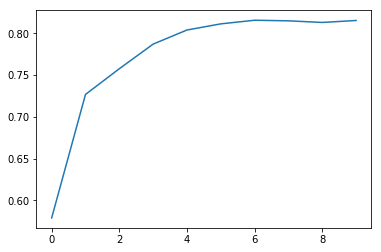

In [92]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [93]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10106875197022706, 0.31583760032841873, 0.978321406018799, 0.8218541799710289]


In [94]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09663724281279411, 0.30714876921629203, 0.9801807887570728, 0.8315210944053156]


In [95]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09378092989892621, 0.31055712046300626, 0.9813350695851865, 0.8277612137430503]


**More trees will not cause overfitting or worse predictions, but the extra trees won't add important insight to the random forest.**

### Out-of-bag (OOB) score

* **Sometimes your dataset will be kind of small and you don't want to pull a validation set.**
* **is This the equivalent of cross-validation but for random forests ?**
* **OOB is unique to random forests.**
* **We know that with each tree in a random forest, some of the rows didn't get used by default.**
* **So what we can do is pass these unused rows as a validation set to the same tree, and do this for all trees than average the validation scores into one.**
* **In this case, we will have a different validation set for each tree.**

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [96]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09624991168882507, 0.3096687378716056, 0.9803393448764974, 0.8287452200507912, 0.8594292353720643]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [100]:
df_trn, y_trn, nas = proc_df(df_train, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: **rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree.** That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [102]:
set_rf_samples(5000)

In [103]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/anaconda3/envs/fastai-env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1.55 s, sys: 101 ms, total: 1.65 s
Wall time: 968 ms
[0.258200425022002, 0.2906782672040498, 0.8618327456442079, 0.8491056081020756, 0.8459441339817202]


**When you do interactive random forest analysis, use subsets and small number of estimators.**

* **All researchers run all of their models on all of the data using maxed hyper-parameters.**
 * **This is just pointless because you waste a lot of resources (time, hardware)**
 * **Do analysis interactively and optimize your parameters to not wait.**
 * **Optimize for the fourth decimal accuracy point after doing data analysis**

Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [104]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.24491807352994177, 0.28164857222354667, 0.8756823215947952, 0.8583348316822141, 0.8609869279566641]


### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [105]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [106]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [107]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.08413338803811199, 0.24644014127845126, 0.985330072137543, 0.8915396823141305, 0.8950214249992415]


In [108]:
t=m.estimators_[0].tree_

In [109]:
dectree_max_depth(t)

40

In [110]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.15123706154968752, 0.24557914998907476, 0.9525967974899909, 0.892296217031861, 0.8923427491706583]


In [111]:
t=m.estimators_[0].tree_

In [112]:
dectree_max_depth(t)

31

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [113]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12285506215957377, 0.24712735319122095, 0.9687192372916141, 0.8909339437783826, 0.8945566111181107]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- **None**
- **0.5**
- **'sqrt'**

- **1, 3, 5, 10, 25, 100**

* **At each binary split, We restrict the chosen columns for split searching to a random choice from 50% of the total columns.**

In [115]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12753894835613544, 0.240587975007174, 0.9662885925234013, 0.8966296926549981, 0.8977978930488546]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:

![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)